### Imports

In [22]:
import sqlite3 as sql
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm

conn = sql.connect("states.db")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()[1:]


dataframes = {}
for table_name in table_names:
    dataframes[table_name] = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

In [3]:
unemployment_rate = dataframes['unemployment_rate']
state_survival_rates = dataframes['survival_rates']
industry_survival_rates = dataframes['industry_survival_rates']
establishments = dataframes['establishments']

### Data reformatting

Reformat into 1530 samples for state data

In [4]:
state_survival_rates_filtered = state_survival_rates[state_survival_rates["Year Established"] != state_survival_rates["Year"]]
state_survival_rates_filtered.loc[:, "Year"] = state_survival_rates_filtered["Year"].astype('int')
state_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = state_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
state_survival_rates_filtered.loc[:, 'Surviving Establishments'] = state_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
state_survival_rates_grouped = state_survival_rates_filtered.groupby(["Year", "State"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
#print(state_survival_rates_filtered.head())

Get reformatted industry data

In [5]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                    

In [6]:
total_survival_rate = pd.concat([state_survival_rates_filtered, industry_survival_rates_filtered])
total_survival_rate_grouped = total_survival_rate.groupby(["Year"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
# ^ overall business survival rate by year



In [10]:
conn = sql.connect("states.db")
state_survival_rates_grouped.unstack().to_sql("states_grouped", conn, if_exists="replace", index=False)
industry_survival_rates_grouped.to_sql("industry_grouped", conn, if_exists="replace", index=False)
total_survival_rate_grouped.to_sql("total_grouped", conn, if_exists="replace", index=False)
conn.close()

### Bayesian Approach

In [11]:
import pandas as pd
import numpy as np

def compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered):
    probabilities = []
    years = state_survival_rates_filtered['Year'].unique() # loop through the unique years in the list

    # P(Survival | State, Sector) = P(Survival) * P(State, Sector | Survival)P(State, Sector)
    
    for year in years:
        df_s = state_survival_rates_filtered[state_survival_rates_filtered['Year'] == year] # data during the current iterated year
        df_i = industry_survival_rates_filtered[industry_survival_rates_filtered['Year'] == year]
        df_state = df_s.copy()
        df_industry = df_i.copy()
       
        df_state.loc[:, 'Total Establishments'] = df_s['Surviving Establishments'].shift(1).fillna(df_s['Surviving Establishments'])
        # total establishments is just the surviving number from the last year
        df_industry.loc[:, 'Total Establishments'] = df_i['Surviving Establishments'].shift(1).fillna(df_i['Surviving Establishments'])
        # making sure the first one has data to shift down also
        
        total_state_survivors = df_state['Surviving Establishments'].sum()
        total_industry_survivors = df_industry['Surviving Establishments'].sum()
        total_survivors = (total_state_survivors + total_industry_survivors) / 2  # still using weighted average for now
        
        total_state_establishments = df_state['Total Establishments'].sum()
        total_industry_establishments = df_industry['Total Establishments'].sum()
        total_establishments = (total_state_establishments + total_industry_establishments) / 2
        
        p_survival = total_survivors / total_establishments if total_establishments > 0 else 0  # P(Survival)
        
        # Compute P(State, Sector) - probability of being in a state-sector
        df_state.loc[:, 'P_State'] = df_state['Total Establishments'] / total_state_establishments
        df_industry.loc[:, 'P_Sector'] = df_industry['Total Establishments'] / total_industry_establishments
        
        # Compute P(State | Survival) and P(Sector | Survival)
        df_state['P_State_given_Survival'] = df_state['Surviving Establishments'] / total_state_survivors
        df_industry['P_Sector_given_Survival'] = df_industry['Surviving Establishments'] / total_industry_survivors
        
        # Merge datasets on state and industry
        df_merged = pd.merge(df_state, df_industry, on='Year', suffixes=('_State', '_Sector'))
        
        # Compute P(Survival | State, Sector) using Bayesian formula
        df_merged['P_Survival_given_State_Sector'] = (
            p_survival * df_merged['P_State_given_Survival'] * df_merged['P_Sector_given_Survival'] /
            (df_merged['P_State'] * df_merged['P_Sector'])
        ).fillna(0)  # Handle divide-by-zero cases
        
        probabilities.append(df_merged[['Year', 'State', 'Industry', 'P_Survival_given_State_Sector']])
    
    return pd.concat(probabilities)

# Example usage

bayesian_survival_probabilities = compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered)
print(bayesian_survival_probabilities.head())


   Year State                                       Industry  \
0  1995    AL     Agriculture, Forestry, Fishing and Hunting   
1  1995    AL  Mining, Quarrying, and Oil and Gas Extraction   
2  1995    AL                                      Utilities   
3  1995    AL                                   Construction   
4  1995    AL                                  Manufacturing   

   P_Survival_given_State_Sector  
0                       0.976189  
1                       0.254581  
2                       0.319087  
3                     100.164821  
4                       0.442390  


### Non-Bayesian approach

In [12]:
results = []
for (year, state), state_val in state_survival_rates_grouped.items():
    for (ind_year, industry), ind_val in industry_survival_rates_grouped.items():
        if year == ind_year:
            result = (year, state, industry), (state_val * ind_val) / total_survival_rate_grouped[year]
            results.append(result)

result = pd.Series(dict(results))
unemployment_rate["Year"] = unemployment_rate["Year"].astype('int')

In [13]:
state_df = state_survival_rates_grouped.unstack()
industry_df = industry_survival_rates_grouped.unstack()

In [14]:
numerical_state = dict(zip(state_df.columns, range(len(state_df.columns))))
numerical_state_rev = dict(zip(range(len(state_df.columns)), state_df.columns))
numerical_industry = dict(zip(industry_df.columns, range(len(industry_df.columns))))
numerical_industry_rev = dict(zip(range(len(industry_df.columns)), industry_df.columns))

In [15]:
pre_df = []
for year in result.index.get_level_values(0).unique():
    for state in state_df.columns:
        unemployment = unemployment_rate[(unemployment_rate["Year"] == year) & (unemployment_rate["State"] == state)]["Unemployment Rate"]
        for industry in industry_df.columns:
            response = result[year, state, industry]
            pre_df.append((year, numerical_state[state], numerical_industry[industry], float(unemployment.iloc[0]), response))
final_dataset = pd.DataFrame(pre_df, columns=["Year", "State", "Industry", "Unemployment Rate", "Response"])
             

### Model

In [16]:
class EconDataset(Dataset):
    def __init__(self, data, state_col, industry_col, unemployment_col, response_col):
        self.data = data.copy()
        self.state_col = state_col
        self.industry_col = industry_col
        self.unemployment_col = unemployment_col
        self.response_col = response_col
        self.state_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.industry_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._preprocess_data()

    def _preprocess_data(self):
        self.encoded_states = self.state_encoder.fit_transform(self.data[[self.state_col]]) # Applying one-hot encoding to the state column
        self.encoded_industries = self.industry_encoder.fit_transform(self.data[[self.industry_col]]) # Applying one-hot encoding to the industry
        self.unemployment_stats = self.data[self.unemployment_col].values.reshape(-1, 1) # Turns into column vector
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state = self.encoded_states[idx]
        industry = self.encoded_industries[idx]
        unemployment = self.unemployment_stats[idx]
        predictor = np.concatenate((unemployment, state, industry), axis=0)
        response = self.data[self.response_col].values[idx]
        return torch.tensor(predictor, dtype=torch.float32), torch.tensor(response, dtype=torch.float32).view(1) #Response is reshaped to a column vector.

In [ ]:
class SurvivalRateModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size = 1):
        super(SurvivalRateModel, self).__init__()

        # Define layers:
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.layers(x)

    
    def train_step(self, x, y, criterion, optimizer):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def train_loop(self, dataloader, num_epochs=100, learning_rate=0.01, device = "cpu"):
        self.to(device)
        criterion = nn.L1Loss()
        loss_cache = []
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.train() #set model to train mode.
        for epoch in tqdm.tqdm(range(num_epochs), desc="Training Epochs"):
            total_loss = 0
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                loss = self.train_step(x, y, criterion, optimizer)
                loss_cache.append(loss)
                total_loss += loss
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')
        return loss_cache
    def evaluate(self, dataloader, device="cpu"):
        self.to(device)
        self.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                outputs = self(x)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y.cpu().numpy())
        return (np.concatenate(predictions), np.concatenate(actuals))
    
    def predict(self, x, device="cpu"):
        self.to(device)
        self.eval()
        with torch.no_grad():
            x = x.to(device)
            return self(x).cpu().numpy()
    

Train test split:

In [74]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(final_dataset, test_size=0.2, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [98]:
input_size = 1 + len(train_dataset.state_encoder.categories_[0]) + len(train_dataset.industry_encoder.categories_[0])
model = SurvivalRateModel(input_size=input_size, hidden_size1=120, hidden_size2=80)
loss_data = model.train_loop(train_dataloader, num_epochs=20, learning_rate=0.01, device="cpu")

Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Epoch [1/20], Loss: 21.1958


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.72it/s]

Epoch [2/20], Loss: 3.0861


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.58it/s]

Epoch [3/20], Loss: 2.8940


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.67it/s]

Epoch [4/20], Loss: 2.7550


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.8401


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.75it/s]

Epoch [6/20], Loss: 2.8572


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.77it/s]

Epoch [7/20], Loss: 2.9030


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8797


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.76it/s]

Epoch [9/20], Loss: 2.7476


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.72it/s]

Epoch [10/20], Loss: 2.8445


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.72it/s]

Epoch [11/20], Loss: 2.7766


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.73it/s]

Epoch [12/20], Loss: 2.8106


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.62it/s]

Epoch [13/20], Loss: 2.8734


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.66it/s]

Epoch [14/20], Loss: 2.7914


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.46it/s]

Epoch [15/20], Loss: 2.8418


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.7316


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.55it/s]

Epoch [17/20], Loss: 2.7715


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.55it/s]

Epoch [18/20], Loss: 2.7386


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.60it/s]

Epoch [19/20], Loss: 2.7373


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

Epoch [20/20], Loss: 2.8122


In [96]:
predicted, actual = Model.evaluate(test_dataloader, device="cpu")
print(f"Evaluation loss: {np.mean(abs(predicted - actual)):1.4f}")

Evaluation loss: 2.5933


Hyperparameter tuning:

In [ ]:
hidden_size_1 = [32, 64, 128, 256]
hidden_size_2 = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [64, 128, 256]
epochs = [5, 10, 20]
results = {}
for h1 in hidden_size_1:
    for h2 in hidden_size_2:
        for lr in learning_rates:
            for bs in batch_sizes:
                for ep in epochs:
                    model = SurvivalRateModel(input_size=input_size, hidden_size1=h1, hidden_size2=h2)
                    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
                    loss_data = model.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu")
                    predicted, actual = model.evaluate(test_dataloader, device="cpu")
                    loss = np.mean(abs(predicted - actual))
                    results[(h1, h2, lr, bs, ep)] = (loss, loss_data)
                    print(f"Hidden Size 1: {h1}, Hidden Size 2: {h2}, Learning Rate: {lr}, Batch Size: {bs}, Epochs: {ep}, Loss: {loss:1.4f}")

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/5], Loss: 6.6032


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.8523


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.52it/s]

Epoch [3/5], Loss: 3.6479


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.53it/s]

Epoch [4/5], Loss: 3.4837


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch [5/5], Loss: 3.4164
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 5.7162


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.40it/s]

Epoch [1/10], Loss: 6.3174


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 4.0264


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

Epoch [3/10], Loss: 3.6017


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Epoch [4/10], Loss: 3.5340


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

Epoch [5/10], Loss: 3.4149


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Epoch [6/10], Loss: 3.2094


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.40it/s]

Epoch [7/10], Loss: 3.1075


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.41it/s]

Epoch [8/10], Loss: 3.0050


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

Epoch [9/10], Loss: 3.0246


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch [10/10], Loss: 3.0611
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7061


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.49it/s]

Epoch [1/20], Loss: 7.0569


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.52it/s]

Epoch [2/20], Loss: 4.2091


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 3.5268


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch [4/20], Loss: 3.5055


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 3.2676


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.49it/s]

Epoch [6/20], Loss: 3.3152


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.50it/s]

Epoch [7/20], Loss: 3.2795


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 3.1470


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch [9/20], Loss: 3.1686


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch [10/20], Loss: 2.9914


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 3.0145


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.9693


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 3.0565


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.45it/s]

Epoch [14/20], Loss: 2.9087


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 2.9726


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.49it/s]

Epoch [16/20], Loss: 2.9560


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.9975


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.39it/s]

Epoch [18/20], Loss: 3.0241


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.9198


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.8214
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.3941


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

Epoch [1/5], Loss: 8.4692


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 3.4849


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 3.6522


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Epoch [4/5], Loss: 3.5709


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 3.3086
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.9590


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.82it/s]

Epoch [1/10], Loss: 7.7047


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 3.8270


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 3.8384


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.82it/s]

Epoch [4/10], Loss: 3.4638


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.4831


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch [6/10], Loss: 3.4045


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Epoch [7/10], Loss: 3.2520


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 3.3535


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

Epoch [9/10], Loss: 3.1121


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 3.1606
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 4.6178


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 8.6846


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.82it/s]

Epoch [2/20], Loss: 3.6956


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 3.4653


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 3.2597


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 3.2478


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 3.2712


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 3.1965


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 3.3961


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 3.1314


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.9313


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.79it/s]

Epoch [11/20], Loss: 3.1875


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

Epoch [12/20], Loss: 3.1034


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.9475


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 3.1698


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch [15/20], Loss: 3.2184


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.82it/s]

Epoch [16/20], Loss: 2.9797


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.82it/s]

Epoch [17/20], Loss: 3.0372


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.77it/s]

Epoch [18/20], Loss: 2.8915


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch [19/20], Loss: 2.8764


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch [20/20], Loss: 2.9485
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7295


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.98it/s]

Epoch [1/5], Loss: 13.2298


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 3.2727


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch [3/5], Loss: 3.1879


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.98it/s]

Epoch [4/5], Loss: 3.6161


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch [5/5], Loss: 3.6323
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.7223


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 13.8346


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 3.1575


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 3.1397


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

Epoch [4/10], Loss: 3.0568


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 3.1312


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 3.1991


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

Epoch [7/10], Loss: 3.2490


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 3.3536


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.77it/s]

Epoch [9/10], Loss: 3.2919


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch [10/10], Loss: 2.9801
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.7119


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.96it/s]

Epoch [1/20], Loss: 12.7012


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.96it/s]

Epoch [2/20], Loss: 3.2662


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.97it/s]

Epoch [3/20], Loss: 3.2296


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.5722


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.91it/s]

Epoch [5/20], Loss: 3.2025


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.93it/s]

Epoch [6/20], Loss: 3.1334


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.94it/s]

Epoch [7/20], Loss: 3.2155


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 3.1116


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.84it/s]

Epoch [9/20], Loss: 3.4459


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.85it/s]

Epoch [10/20], Loss: 2.9924


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.88it/s]

Epoch [11/20], Loss: 3.4566


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.91it/s]

Epoch [12/20], Loss: 3.0748


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.83it/s]

Epoch [13/20], Loss: 3.1488


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.88it/s]

Epoch [14/20], Loss: 2.9670


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.90it/s]

Epoch [15/20], Loss: 2.9855


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.93it/s]

Epoch [16/20], Loss: 3.0104


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.94it/s]

Epoch [17/20], Loss: 3.6788


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.95it/s]

Epoch [18/20], Loss: 2.9850


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.71it/s]

Epoch [19/20], Loss: 3.1568


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch [20/20], Loss: 2.8855
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.6468


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [1/5], Loss: 11.8542


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Epoch [2/5], Loss: 2.8822


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 2.8866


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.8156


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.8236
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6995


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Epoch [1/10], Loss: 13.4128


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.53it/s]

Epoch [2/10], Loss: 2.9203


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8995


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.53it/s]

Epoch [4/10], Loss: 2.9362


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Epoch [5/10], Loss: 2.8762


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.50it/s]

Epoch [6/10], Loss: 2.8710


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.9123


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.8506


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.41it/s]

Epoch [9/10], Loss: 2.8971


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.8356
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.4511


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.54it/s]

Epoch [1/20], Loss: 13.3644


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 2.8752


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

Epoch [3/20], Loss: 2.9150


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.51it/s]

Epoch [4/20], Loss: 2.8867


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 2.8845


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.8482


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.46it/s]

Epoch [7/20], Loss: 2.8635


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.48it/s]

Epoch [8/20], Loss: 2.8584


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.50it/s]

Epoch [9/20], Loss: 2.8523


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.8568


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.50it/s]

Epoch [11/20], Loss: 2.8266


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8407


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

Epoch [13/20], Loss: 2.8022


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.37it/s]

Epoch [14/20], Loss: 2.7671


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.41it/s]

Epoch [15/20], Loss: 2.7908


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.7810


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.47it/s]

Epoch [17/20], Loss: 2.7856


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.49it/s]

Epoch [18/20], Loss: 2.7355


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.50it/s]

Epoch [19/20], Loss: 2.7803


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7620
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.9213


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.80it/s]

Epoch [1/5], Loss: 20.4339


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Epoch [2/5], Loss: 2.8183


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Epoch [3/5], Loss: 2.9192


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.8090


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch [5/5], Loss: 2.8435
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6779


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

Epoch [1/10], Loss: 20.8064


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.81it/s]

Epoch [2/10], Loss: 2.8413


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 2.8323


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.78it/s]

Epoch [4/10], Loss: 2.8294


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.79it/s]

Epoch [5/10], Loss: 2.8443


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.8051


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.71it/s]

Epoch [7/10], Loss: 2.8447


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.8073


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.8066


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch [10/10], Loss: 2.8833
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7762


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 22.5280


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 2.8601


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 2.8085


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 2.8016


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 2.8210


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 2.7779


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.72it/s]

Epoch [7/20], Loss: 2.7570


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 2.7903


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 2.7683


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.7268


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.7706


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

Epoch [12/20], Loss: 2.7238


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.79it/s]

Epoch [13/20], Loss: 2.7152


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.77it/s]

Epoch [14/20], Loss: 2.7339


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.77it/s]

Epoch [15/20], Loss: 2.7104


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

Epoch [16/20], Loss: 2.7017


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.71it/s]

Epoch [17/20], Loss: 2.7113


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

Epoch [18/20], Loss: 2.7424


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.7351


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch [20/20], Loss: 2.7338
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.5827


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.97it/s]

Epoch [1/5], Loss: 36.4855


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Epoch [2/5], Loss: 6.4041


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

Epoch [3/5], Loss: 2.7751


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]

Epoch [4/5], Loss: 2.7648


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch [5/5], Loss: 2.7723
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7694


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 36.9497


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 6.0609


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 2.7874


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.97it/s]

Epoch [4/10], Loss: 2.7633


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch [5/10], Loss: 2.7624


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.95it/s]

Epoch [6/10], Loss: 2.8007


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.96it/s]

Epoch [7/10], Loss: 2.7615


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.96it/s]

Epoch [8/10], Loss: 2.7526


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.7464


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [10/10], Loss: 2.7957
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6853


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.91it/s]

Epoch [1/20], Loss: 40.4232


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.96it/s]

Epoch [2/20], Loss: 7.3446


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.96it/s]

Epoch [3/20], Loss: 2.8248


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch [4/20], Loss: 2.7318


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.7360


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.7426


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.85it/s]

Epoch [7/20], Loss: 2.7321


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.74it/s]

Epoch [8/20], Loss: 2.7135


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.80it/s]

Epoch [9/20], Loss: 2.7068


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.87it/s]

Epoch [10/20], Loss: 2.7228


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.89it/s]

Epoch [11/20], Loss: 2.6853


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.90it/s]

Epoch [12/20], Loss: 2.6780


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.93it/s]

Epoch [13/20], Loss: 2.6849


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.91it/s]

Epoch [14/20], Loss: 2.6732


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6914


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6802


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.89it/s]

Epoch [17/20], Loss: 2.6725


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.91it/s]

Epoch [18/20], Loss: 2.6579


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.93it/s]

Epoch [19/20], Loss: 2.7159


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch [20/20], Loss: 2.6635
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7109


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [1/5], Loss: 50.9014


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 11.1332


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 4.5454


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.7236


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 2.7069
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6130


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.37it/s]

Epoch [1/10], Loss: 48.4146


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 9.7109


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 3.5182


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.7055


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.52it/s]

Epoch [5/10], Loss: 2.7080


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.53it/s]

Epoch [6/10], Loss: 2.7029


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Epoch [7/10], Loss: 2.7002


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

Epoch [8/10], Loss: 2.6993


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]

Epoch [9/10], Loss: 2.7005


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch [10/10], Loss: 2.6954
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5993


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.52it/s]

Epoch [1/20], Loss: 52.2134


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.53it/s]

Epoch [2/20], Loss: 11.1954


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]

Epoch [3/20], Loss: 4.3962


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.7174


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 2.6996


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.51it/s]

Epoch [6/20], Loss: 2.6953


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.51it/s]

Epoch [7/20], Loss: 2.7024


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 2.6990


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

Epoch [9/20], Loss: 2.6934


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.40it/s]

Epoch [10/20], Loss: 2.6905


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.6959


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.46it/s]

Epoch [12/20], Loss: 2.7041


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.49it/s]

Epoch [13/20], Loss: 2.7051


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.6951


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.50it/s]

Epoch [15/20], Loss: 2.7036


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

Epoch [16/20], Loss: 2.6912


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.7056


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 2.6968


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.6956


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7030
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6073


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.75it/s]

Epoch [1/5], Loss: 75.8351


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 16.6784


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 11.6296


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.81it/s]

Epoch [4/5], Loss: 7.4690


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 3.8934
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.7499


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.87it/s]

Epoch [1/10], Loss: 72.6286


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.73it/s]

Epoch [2/10], Loss: 15.7825


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 11.3614


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.81it/s]

Epoch [4/10], Loss: 7.2010


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.8531


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Epoch [6/10], Loss: 2.7281


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 2.6947


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

Epoch [8/10], Loss: 2.6875


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

Epoch [9/10], Loss: 2.6897


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch [10/10], Loss: 2.6874
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5904


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.88it/s]

Epoch [1/20], Loss: 78.1230


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 18.2200


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

Epoch [3/20], Loss: 12.3681


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 8.3226


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 4.9423


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 2.9184


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.82it/s]

Epoch [7/20], Loss: 2.6949


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.6910


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Epoch [9/20], Loss: 2.6812


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.6855


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 2.6857


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch [12/20], Loss: 2.6848


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.84it/s]

Epoch [13/20], Loss: 2.6805


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 2.6945


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.85it/s]

Epoch [15/20], Loss: 2.6802


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.85it/s]

Epoch [16/20], Loss: 2.6883


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.85it/s]

Epoch [17/20], Loss: 2.6814


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.85it/s]

Epoch [18/20], Loss: 2.6844


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.75it/s]

Epoch [19/20], Loss: 2.6878


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.6913
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5805


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.03it/s]

Epoch [1/5], Loss: 87.8455


Training Epochs:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Epoch [2/5], Loss: 65.4947


Training Epochs:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Epoch [3/5], Loss: 18.4449


Training Epochs:  80%|████████  | 4/5 [00:01<00:00,  2.04it/s]

Epoch [4/5], Loss: 13.9984


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch [5/5], Loss: 11.9451
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 10.9758


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 88.7476


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 73.6968


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Epoch [3/10], Loss: 22.7495


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.99it/s]

Epoch [4/10], Loss: 14.6509


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.99it/s]

Epoch [5/10], Loss: 12.5837


Training Epochs:  60%|██████    | 6/10 [00:03<00:01,  2.00it/s]

Epoch [6/10], Loss: 10.4010


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

Epoch [7/10], Loss: 8.3222


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch [8/10], Loss: 6.4639


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 4.6872


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch [10/10], Loss: 3.2855
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.8053


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch [1/20], Loss: 87.8925


Training Epochs:  10%|█         | 2/20 [00:00<00:08,  2.01it/s]

Epoch [2/20], Loss: 63.1954


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  2.00it/s]

Epoch [3/20], Loss: 17.6778


Training Epochs:  20%|██        | 4/20 [00:01<00:07,  2.01it/s]

Epoch [4/20], Loss: 13.7628


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  2.00it/s]

Epoch [5/20], Loss: 11.2175


Training Epochs:  30%|███       | 6/20 [00:02<00:06,  2.01it/s]

Epoch [6/20], Loss: 8.6168


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  2.01it/s]

Epoch [7/20], Loss: 6.1578


Training Epochs:  40%|████      | 8/20 [00:03<00:05,  2.01it/s]

Epoch [8/20], Loss: 3.9796


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  2.01it/s]

Epoch [9/20], Loss: 2.8373


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.6834


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6792


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.88it/s]

Epoch [12/20], Loss: 2.6800


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.6762


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.90it/s]

Epoch [14/20], Loss: 2.6787


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6780


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6760


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.96it/s]

Epoch [17/20], Loss: 2.6796


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.98it/s]

Epoch [18/20], Loss: 2.6776


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.99it/s]

Epoch [19/20], Loss: 2.6802


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch [20/20], Loss: 2.6766
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5801


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 6.7739


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.56it/s]

Epoch [2/5], Loss: 3.9813


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 3.4695


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

Epoch [4/5], Loss: 3.1451


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [5/5], Loss: 2.8441
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.6144


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.7951


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Epoch [2/10], Loss: 4.1487


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.50it/s]

Epoch [3/10], Loss: 3.7468


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Epoch [4/10], Loss: 3.7238


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]

Epoch [5/10], Loss: 3.2091


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.54it/s]

Epoch [6/10], Loss: 3.3183


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 3.1805


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

Epoch [8/10], Loss: 3.1020


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.55it/s]

Epoch [9/10], Loss: 3.1222


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch [10/10], Loss: 3.0798
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.6621


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 6.8097


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

Epoch [2/20], Loss: 3.9057


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 3.7259


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Epoch [4/20], Loss: 3.6098


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Epoch [5/20], Loss: 3.4496


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 3.2046


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.40it/s]

Epoch [7/20], Loss: 3.2018


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch [8/20], Loss: 3.0459


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch [9/20], Loss: 3.0101


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.46it/s]

Epoch [10/20], Loss: 3.1053


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 3.0052


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8634


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.7903


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8394


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.7715


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.7556


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.47it/s]

Epoch [17/20], Loss: 2.7163


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.37it/s]

Epoch [18/20], Loss: 2.7508


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.40it/s]

Epoch [19/20], Loss: 2.7871


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.7597
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6051


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Epoch [1/5], Loss: 8.2501


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Epoch [2/5], Loss: 3.8004


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Epoch [3/5], Loss: 3.6815


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Epoch [4/5], Loss: 3.4654


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 3.6191
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 4.3023


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.32it/s]

Epoch [1/10], Loss: 7.8577


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 3.6617


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.66it/s]

Epoch [3/10], Loss: 3.3953


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.72it/s]

Epoch [4/10], Loss: 3.3388


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 3.2518


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 3.3196


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

Epoch [7/10], Loss: 4.0043


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.66it/s]

Epoch [8/10], Loss: 3.0367


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

Epoch [9/10], Loss: 3.0370


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch [10/10], Loss: 3.0329
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.7480


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Epoch [1/20], Loss: 7.8735


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.76it/s]

Epoch [2/20], Loss: 4.2697


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.79it/s]

Epoch [3/20], Loss: 3.9425


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.80it/s]

Epoch [4/20], Loss: 3.3581


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 3.6379


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 3.3136


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 3.2177


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 3.1107


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.80it/s]

Epoch [9/20], Loss: 3.1455


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 3.1931


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 3.1019


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch [12/20], Loss: 2.9679


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.9716


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 3.0128


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.84it/s]

Epoch [15/20], Loss: 3.0373


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.84it/s]

Epoch [16/20], Loss: 2.9709


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.84it/s]

Epoch [17/20], Loss: 2.9958


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.9696


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.9040


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.7869
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7392


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 12.6916


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.7024


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 3.7929


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 3.3416


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 3.3020
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.7590


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 10.3247


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 3.6655


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

Epoch [3/10], Loss: 4.4277


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.94it/s]

Epoch [4/10], Loss: 3.9615


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

Epoch [5/10], Loss: 3.1680


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 3.3549


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

Epoch [7/10], Loss: 3.6470


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.88it/s]

Epoch [8/10], Loss: 3.3879


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Epoch [9/10], Loss: 3.0944


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [10/10], Loss: 3.1486
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 3.9738


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch [1/20], Loss: 12.5533


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.97it/s]

Epoch [2/20], Loss: 3.6716


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.98it/s]

Epoch [3/20], Loss: 3.8406


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.99it/s]

Epoch [4/20], Loss: 3.2480


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.99it/s]

Epoch [5/20], Loss: 3.2863


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.87it/s]

Epoch [6/20], Loss: 3.3117


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.89it/s]

Epoch [7/20], Loss: 3.3914


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 3.2232


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]

Epoch [9/20], Loss: 3.0579


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.95it/s]

Epoch [10/20], Loss: 3.1215


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.97it/s]

Epoch [11/20], Loss: 3.0557


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.98it/s]

Epoch [12/20], Loss: 3.2955


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.99it/s]

Epoch [13/20], Loss: 3.2582


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.99it/s]

Epoch [14/20], Loss: 3.2245


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  2.00it/s]

Epoch [15/20], Loss: 3.0350


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 3.0922


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.82it/s]

Epoch [17/20], Loss: 3.2714


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.87it/s]

Epoch [18/20], Loss: 2.8967


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.84it/s]

Epoch [19/20], Loss: 3.1597


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch [20/20], Loss: 2.9767
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 4.5298


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [1/5], Loss: 11.8278


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 2.9630


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 2.9772


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.8959


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [5/5], Loss: 2.9336
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7277


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 11.3857


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 2.9830


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch [3/10], Loss: 2.9398


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.55it/s]

Epoch [4/10], Loss: 2.9583


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.9539


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

Epoch [6/10], Loss: 2.9862


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 2.8439


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.8457


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 2.7908


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch [10/10], Loss: 2.8191
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7022


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 11.3749


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.55it/s]

Epoch [2/20], Loss: 2.9843


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch [3/20], Loss: 2.9810


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch [4/20], Loss: 2.9600


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.49it/s]

Epoch [5/20], Loss: 3.0182


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.51it/s]

Epoch [6/20], Loss: 2.8673


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.8266


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 2.8297


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Epoch [9/20], Loss: 2.8367


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.54it/s]

Epoch [10/20], Loss: 2.8333


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 2.8298


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.8155


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.8474


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8611


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 2.8327


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.49it/s]

Epoch [16/20], Loss: 2.8295


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.8133


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.8277


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

Epoch [19/20], Loss: 2.8459


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 2.8188
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6678


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Epoch [1/5], Loss: 16.8262


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 2.8953


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

Epoch [3/5], Loss: 2.8828


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 2.9978


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [5/5], Loss: 2.8519
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7347


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Epoch [1/10], Loss: 17.9804


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 2.8754


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 2.8497


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.85it/s]

Epoch [4/10], Loss: 2.8562


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Epoch [5/10], Loss: 2.8450


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Epoch [6/10], Loss: 2.8849


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 2.8865


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.85it/s]

Epoch [8/10], Loss: 2.8781


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.8693


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch [10/10], Loss: 2.8602
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6355


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 18.7390


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 2.8738


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.74it/s]

Epoch [3/20], Loss: 2.9488


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 2.9017


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 2.8579


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 2.8268


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.83it/s]

Epoch [7/20], Loss: 2.8267


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch [8/20], Loss: 2.8251


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.84it/s]

Epoch [9/20], Loss: 2.7735


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.84it/s]

Epoch [10/20], Loss: 2.7955


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.8243


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.85it/s]

Epoch [12/20], Loss: 2.8162


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.7934


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.8383


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.78it/s]

Epoch [15/20], Loss: 2.8286


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.80it/s]

Epoch [16/20], Loss: 2.7727


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.81it/s]

Epoch [17/20], Loss: 2.7528


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.82it/s]

Epoch [18/20], Loss: 2.7945


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.8184


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch [20/20], Loss: 2.7651
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6578


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.02it/s]

Epoch [1/5], Loss: 32.0796


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 4.9092


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

Epoch [3/5], Loss: 2.7620


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 2.7846


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 2.8086
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7407


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 31.8106


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 4.6702


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.01it/s]

Epoch [3/10], Loss: 2.8053


Training Epochs:  40%|████      | 4/10 [00:01<00:02,  2.01it/s]

Epoch [4/10], Loss: 2.7773


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.01it/s]

Epoch [5/10], Loss: 2.7209


Training Epochs:  60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

Epoch [6/10], Loss: 2.7140


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.01it/s]

Epoch [7/10], Loss: 2.6979


Training Epochs:  80%|████████  | 8/10 [00:03<00:00,  2.01it/s]

Epoch [8/10], Loss: 2.7381


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  2.01it/s]

Epoch [9/10], Loss: 2.6932


Training Epochs: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch [10/10], Loss: 2.7399
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5971


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch [1/20], Loss: 31.4597


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.73it/s]

Epoch [2/20], Loss: 4.8552


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.84it/s]

Epoch [3/20], Loss: 2.7962


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 2.7696


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.85it/s]

Epoch [5/20], Loss: 2.7900


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.90it/s]

Epoch [6/20], Loss: 2.8078


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.93it/s]

Epoch [7/20], Loss: 2.7710


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.95it/s]

Epoch [8/20], Loss: 2.7808


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.97it/s]

Epoch [9/20], Loss: 2.8242


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.98it/s]

Epoch [10/20], Loss: 2.8225


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.98it/s]

Epoch [11/20], Loss: 2.7770


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.98it/s]

Epoch [12/20], Loss: 2.8342


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.99it/s]

Epoch [13/20], Loss: 2.7775


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.99it/s]

Epoch [14/20], Loss: 2.7925


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.99it/s]

Epoch [15/20], Loss: 2.7771


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.92it/s]

Epoch [16/20], Loss: 2.8517


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.94it/s]

Epoch [17/20], Loss: 2.7841


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.95it/s]

Epoch [18/20], Loss: 2.7691


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.8049


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.7731
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7274


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 44.9127


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.56it/s]

Epoch [2/5], Loss: 9.5005


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.56it/s]

Epoch [3/5], Loss: 3.4758


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

Epoch [4/5], Loss: 2.7119


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [5/5], Loss: 2.7028
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6625


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 42.5129


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.56it/s]

Epoch [2/10], Loss: 8.1101


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.56it/s]

Epoch [3/10], Loss: 2.9696


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.7146


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 2.7118


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.53it/s]

Epoch [6/10], Loss: 2.7012


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.54it/s]

Epoch [7/10], Loss: 2.7024


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.54it/s]

Epoch [8/10], Loss: 2.7052


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.55it/s]

Epoch [9/10], Loss: 2.7068


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch [10/10], Loss: 2.7046
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6260


Training Epochs:   5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

Epoch [1/20], Loss: 41.2696


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.14it/s]

Epoch [2/20], Loss: 7.6747


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.30it/s]

Epoch [3/20], Loss: 2.8686


Training Epochs:  20%|██        | 4/20 [00:03<00:11,  1.39it/s]

Epoch [4/20], Loss: 2.7059


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 2.7044


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch [6/20], Loss: 2.7064


Training Epochs:  35%|███▌      | 7/20 [00:05<00:08,  1.46it/s]

Epoch [7/20], Loss: 2.7205


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7083


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.51it/s]

Epoch [9/20], Loss: 2.7044


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.52it/s]

Epoch [10/20], Loss: 2.7014


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Epoch [11/20], Loss: 2.7157


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.54it/s]

Epoch [12/20], Loss: 2.7089


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.55it/s]

Epoch [13/20], Loss: 2.7068


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.55it/s]

Epoch [14/20], Loss: 2.7048


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.55it/s]

Epoch [15/20], Loss: 2.6999


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.55it/s]

Epoch [16/20], Loss: 2.7068


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.6957


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7090


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.7037


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.7057
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6140


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 67.7216


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 13.5635


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Epoch [3/5], Loss: 7.6140


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 3.5695


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch [5/5], Loss: 2.7255
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6499


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Epoch [1/10], Loss: 70.5373


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 14.5325


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 8.6714


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 3.7293


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.77it/s]

Epoch [5/10], Loss: 2.7033


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.7012


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Epoch [7/10], Loss: 2.6951


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Epoch [8/10], Loss: 2.6970


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.82it/s]

Epoch [9/10], Loss: 2.7048


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.6970
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6328


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 71.8990


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 14.9940


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.85it/s]

Epoch [3/20], Loss: 9.9303


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.85it/s]

Epoch [4/20], Loss: 5.5045


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.78it/s]

Epoch [5/20], Loss: 2.9359


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.7011


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 2.7009


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch [8/20], Loss: 2.6918


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.83it/s]

Epoch [9/20], Loss: 2.6889


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.84it/s]

Epoch [10/20], Loss: 2.6931


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6933


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.84it/s]

Epoch [12/20], Loss: 2.6897


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.6868


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.7049


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.85it/s]

Epoch [15/20], Loss: 2.6952


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

Epoch [16/20], Loss: 2.6963


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 2.6901


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.82it/s]

Epoch [18/20], Loss: 2.6883


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.6932


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.6912
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5929


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.37it/s]

Epoch [1/5], Loss: 87.0871


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.65it/s]

Epoch [2/5], Loss: 48.4751


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 15.8656


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 13.0737


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 10.2383
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 8.8863


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 86.4282


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 44.8601


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.83it/s]

Epoch [3/10], Loss: 14.6429


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 11.1085


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.94it/s]

Epoch [5/10], Loss: 7.7985


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.96it/s]

Epoch [6/10], Loss: 4.8408


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.98it/s]

Epoch [7/10], Loss: 2.9793


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.99it/s]

Epoch [8/10], Loss: 2.6957


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.99it/s]

Epoch [9/10], Loss: 2.6931


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch [10/10], Loss: 2.6835
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5906


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.01it/s]

Epoch [1/20], Loss: 87.4677


Training Epochs:  10%|█         | 2/20 [00:00<00:08,  2.02it/s]

Epoch [2/20], Loss: 55.6463


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

Epoch [3/20], Loss: 16.3891


Training Epochs:  20%|██        | 4/20 [00:01<00:08,  2.00it/s]

Epoch [4/20], Loss: 13.7946


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.93it/s]

Epoch [5/20], Loss: 11.0109


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.96it/s]

Epoch [6/20], Loss: 8.3726


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.73it/s]

Epoch [7/20], Loss: 6.0583


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 3.9648


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.86it/s]

Epoch [9/20], Loss: 2.8567


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.6867


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.6813


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.95it/s]

Epoch [12/20], Loss: 2.6794


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.97it/s]

Epoch [13/20], Loss: 2.6828


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.98it/s]

Epoch [14/20], Loss: 2.6795


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.99it/s]

Epoch [15/20], Loss: 2.6768


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch [16/20], Loss: 2.6827


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.92it/s]

Epoch [17/20], Loss: 2.6768


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.94it/s]

Epoch [18/20], Loss: 2.6750


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.6776


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.6896
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5813


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 6.4770


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 3.9569


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 3.2859


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.9023


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [5/5], Loss: 2.9139
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.5566


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.7647


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 3.9064


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch [3/10], Loss: 3.5559


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.55it/s]

Epoch [4/10], Loss: 3.2464


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.8587


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

Epoch [6/10], Loss: 2.8017


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 2.7896


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

Epoch [8/10], Loss: 2.8423


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.44it/s]

Epoch [9/10], Loss: 2.8452


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.8080
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.8183


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.33it/s]

Epoch [1/20], Loss: 6.8455


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.45it/s]

Epoch [2/20], Loss: 3.7768


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 3.0733


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.52it/s]

Epoch [4/20], Loss: 2.9493


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 2.8084


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Epoch [6/20], Loss: 2.8053


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.54it/s]

Epoch [7/20], Loss: 2.8273


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.54it/s]

Epoch [8/20], Loss: 2.8625


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Epoch [9/20], Loss: 2.8326


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.55it/s]

Epoch [10/20], Loss: 2.8598


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.55it/s]

Epoch [11/20], Loss: 2.8855


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8712


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.9460


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8842


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 2.8830


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.9912


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.9681


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

Epoch [18/20], Loss: 2.9466


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

Epoch [19/20], Loss: 3.0090


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch [20/20], Loss: 3.0054
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.9921


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 8.9110


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 4.1421


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 3.5609


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Epoch [4/5], Loss: 3.8853


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch [5/5], Loss: 3.3372
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.0762


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 7.8884


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 3.8445


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 4.0362


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Epoch [4/10], Loss: 3.4450


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

Epoch [5/10], Loss: 3.3515


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.84it/s]

Epoch [6/10], Loss: 3.3355


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 3.0984


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.9347


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.80it/s]

Epoch [9/10], Loss: 2.8688


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch [10/10], Loss: 2.7619
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.5430


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 8.7180


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 4.1631


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.85it/s]

Epoch [3/20], Loss: 3.5916


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.85it/s]

Epoch [4/20], Loss: 3.6277


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.85it/s]

Epoch [5/20], Loss: 3.3873


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.84it/s]

Epoch [6/20], Loss: 3.2920


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.84it/s]

Epoch [7/20], Loss: 3.3854


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 3.0250


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.9547


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.80it/s]

Epoch [10/20], Loss: 2.7901


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.81it/s]

Epoch [11/20], Loss: 2.8517


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.82it/s]

Epoch [12/20], Loss: 2.7874


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.6969


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.83it/s]

Epoch [14/20], Loss: 2.6577


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

Epoch [15/20], Loss: 2.7448


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.83it/s]

Epoch [16/20], Loss: 2.6934


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.76it/s]

Epoch [17/20], Loss: 2.7905


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.7301


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.7248


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Epoch [20/20], Loss: 2.7498
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.9189


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 11.0442


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.9774


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 3.3728


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 3.9575


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 3.1928
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.8502


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 12.7853


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.58it/s]

Epoch [2/10], Loss: 3.8018


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.65it/s]

Epoch [3/10], Loss: 3.9296


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.77it/s]

Epoch [4/10], Loss: 4.1792


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Epoch [5/10], Loss: 4.3247


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.89it/s]

Epoch [6/10], Loss: 3.2020


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Epoch [7/10], Loss: 3.5810


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.96it/s]

Epoch [8/10], Loss: 3.0663


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.97it/s]

Epoch [9/10], Loss: 3.0967


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9595
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.6438


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.00it/s]

Epoch [1/20], Loss: 13.6772


Training Epochs:  10%|█         | 2/20 [00:01<00:08,  2.00it/s]

Epoch [2/20], Loss: 5.5370


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  2.00it/s]

Epoch [3/20], Loss: 3.8486


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.4000


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch [5/20], Loss: 3.3316


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.95it/s]

Epoch [6/20], Loss: 3.4167


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.96it/s]

Epoch [7/20], Loss: 3.5073


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.97it/s]

Epoch [8/20], Loss: 3.2890


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.98it/s]

Epoch [9/20], Loss: 3.1386


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.99it/s]

Epoch [10/20], Loss: 3.7552


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.99it/s]

Epoch [11/20], Loss: 3.1948


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  2.00it/s]

Epoch [12/20], Loss: 3.1167


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.79it/s]

Epoch [13/20], Loss: 3.1773


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.77it/s]

Epoch [14/20], Loss: 3.0960


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.83it/s]

Epoch [15/20], Loss: 3.4139


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch [16/20], Loss: 3.0807


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.91it/s]

Epoch [17/20], Loss: 3.0610


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.93it/s]

Epoch [18/20], Loss: 3.0219


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.95it/s]

Epoch [19/20], Loss: 3.0161


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.8668
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.5985


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [1/5], Loss: 10.1965


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 3.1451


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 3.0027


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Epoch [4/5], Loss: 2.9678


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [5/5], Loss: 2.9638
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6626


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Epoch [1/10], Loss: 10.3038


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 2.9888


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8705


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Loss: 2.9058


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

Epoch [5/10], Loss: 2.8814


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.48it/s]

Epoch [6/10], Loss: 2.8619


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.9965


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.8796


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.50it/s]

Epoch [9/10], Loss: 2.8360


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch [10/10], Loss: 2.8758
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7707


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.56it/s]

Epoch [1/20], Loss: 10.1787


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

Epoch [2/20], Loss: 2.9669


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 2.9335


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Epoch [4/20], Loss: 2.9124


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Epoch [5/20], Loss: 2.9495


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 2.9214


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.55it/s]

Epoch [7/20], Loss: 2.8331


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.55it/s]

Epoch [8/20], Loss: 2.9658


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.55it/s]

Epoch [9/20], Loss: 2.8082


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.9008


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.52it/s]

Epoch [11/20], Loss: 2.8691


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Epoch [12/20], Loss: 2.9069


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.54it/s]

Epoch [13/20], Loss: 2.8285


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.54it/s]

Epoch [14/20], Loss: 2.8780


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.8450


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.8174


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.8289


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

Epoch [18/20], Loss: 2.8303


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.50it/s]

Epoch [19/20], Loss: 2.8639


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


Epoch [20/20], Loss: 2.7959
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6792


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

Epoch [1/5], Loss: 16.8174


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.84it/s]

Epoch [2/5], Loss: 2.8975


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 2.9451


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 2.8475


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch [5/5], Loss: 2.8726
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7032


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 15.2006


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.84it/s]

Epoch [2/10], Loss: 2.9148


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 2.9063


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Epoch [4/10], Loss: 2.8399


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

Epoch [5/10], Loss: 2.8363


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.8150


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.78it/s]

Epoch [7/10], Loss: 2.7981


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 2.7469


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]

Epoch [9/10], Loss: 2.8176


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.8325
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.9310


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 15.8032


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 2.9542


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.84it/s]

Epoch [3/20], Loss: 2.8730


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

Epoch [4/20], Loss: 2.9042


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 2.9101


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 2.8679


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch [7/20], Loss: 2.8985


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 2.8660


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.82it/s]

Epoch [9/20], Loss: 2.8565


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 2.8890


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 2.9512


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.82it/s]

Epoch [12/20], Loss: 2.8673


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.8326


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.83it/s]

Epoch [14/20], Loss: 2.8763


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.78it/s]

Epoch [15/20], Loss: 2.8390


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

Epoch [16/20], Loss: 2.8282


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 2.9447


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.81it/s]

Epoch [18/20], Loss: 2.8412


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.8452


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.8552
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.7160


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 26.7666


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.1679


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 2.8124


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 2.8137


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch [5/5], Loss: 2.8489
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6882


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 28.3003


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.00it/s]

Epoch [2/10], Loss: 3.4427


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Epoch [3/10], Loss: 2.8770


Training Epochs:  40%|████      | 4/10 [00:01<00:03,  2.00it/s]

Epoch [4/10], Loss: 2.7676


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.00it/s]

Epoch [5/10], Loss: 2.7736


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  2.00it/s]

Epoch [6/10], Loss: 2.7632


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

Epoch [7/10], Loss: 2.7911


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 2.8244


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

Epoch [9/10], Loss: 2.7088


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch [10/10], Loss: 2.7300
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5849


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.01it/s]

Epoch [1/20], Loss: 26.4953


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.99it/s]

Epoch [2/20], Loss: 3.0652


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

Epoch [3/20], Loss: 2.8631


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.99it/s]

Epoch [4/20], Loss: 2.8487


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.99it/s]

Epoch [5/20], Loss: 2.8285


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  2.00it/s]

Epoch [6/20], Loss: 2.8102


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.99it/s]

Epoch [7/20], Loss: 2.7870


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.99it/s]

Epoch [8/20], Loss: 2.8559


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.99it/s]

Epoch [9/20], Loss: 2.8717


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.90it/s]

Epoch [10/20], Loss: 2.8121


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.8745


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.95it/s]

Epoch [12/20], Loss: 2.7998


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.96it/s]

Epoch [13/20], Loss: 2.7813


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.97it/s]

Epoch [14/20], Loss: 2.8500


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.98it/s]

Epoch [15/20], Loss: 2.7931


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.99it/s]

Epoch [16/20], Loss: 2.7673


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.99it/s]

Epoch [17/20], Loss: 2.7867


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.99it/s]

Epoch [18/20], Loss: 2.8412


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.8097


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch [20/20], Loss: 2.7961
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.8541


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 33.6428


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 4.7684


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 2.7413


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Epoch [4/5], Loss: 2.7340


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 2.7239
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6350


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 36.2463


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 5.1768


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.7215


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.39it/s]

Epoch [4/10], Loss: 2.7180


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

Epoch [5/10], Loss: 2.7183


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.42it/s]

Epoch [6/10], Loss: 2.7288


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.45it/s]

Epoch [7/10], Loss: 2.7130


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.7162


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.49it/s]

Epoch [9/10], Loss: 2.7243


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.7444
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6179


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.54it/s]

Epoch [1/20], Loss: 36.2589


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 5.0014


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

Epoch [3/20], Loss: 2.7432


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.49it/s]

Epoch [4/20], Loss: 2.7212


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 2.7297


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.7217


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.7164


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 2.7188


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

Epoch [9/20], Loss: 2.7139


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Epoch [10/20], Loss: 2.7264


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Epoch [11/20], Loss: 2.7321


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Epoch [12/20], Loss: 2.7132


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.47it/s]

Epoch [13/20], Loss: 2.7167


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.48it/s]

Epoch [14/20], Loss: 2.7130


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.50it/s]

Epoch [15/20], Loss: 2.7201


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

Epoch [16/20], Loss: 2.7194


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.7203


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7164


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.7152


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 2.7100
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5958


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

Epoch [1/5], Loss: 59.5386


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 12.2652


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

Epoch [3/5], Loss: 5.6796


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 2.7823


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7129
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5922


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch [1/10], Loss: 57.3751


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 12.7828


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.83it/s]

Epoch [3/10], Loss: 6.5583


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.82it/s]

Epoch [4/10], Loss: 2.9528


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 2.6981


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch [6/10], Loss: 2.7037


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

Epoch [7/10], Loss: 2.7000


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.6999


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.80it/s]

Epoch [9/10], Loss: 2.6990


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.7060
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6190


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 57.3993


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 12.3787


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 5.8389


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 2.8137


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 2.7044


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 2.7048


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.7140


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 2.6999


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.7131


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.7071


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.80it/s]

Epoch [11/20], Loss: 2.7060


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.81it/s]

Epoch [12/20], Loss: 2.7022


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.6919


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.7102


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.81it/s]

Epoch [15/20], Loss: 2.7047


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 2.6987


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7071


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.79it/s]

Epoch [18/20], Loss: 2.7092


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.6980


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch [20/20], Loss: 2.6925
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5903


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.01it/s]

Epoch [1/5], Loss: 84.0491


Training Epochs:  40%|████      | 2/5 [00:00<00:01,  2.02it/s]

Epoch [2/5], Loss: 29.9688


Training Epochs:  60%|██████    | 3/5 [00:01<00:00,  2.01it/s]

Epoch [3/5], Loss: 13.8882


Training Epochs:  80%|████████  | 4/5 [00:01<00:00,  1.99it/s]

Epoch [4/5], Loss: 10.2094


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch [5/5], Loss: 6.7540
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.0807


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 84.4500


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch [2/10], Loss: 32.8310


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 14.1350


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.98it/s]

Epoch [4/10], Loss: 11.1191


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.98it/s]

Epoch [5/10], Loss: 8.1639


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.97it/s]

Epoch [6/10], Loss: 5.4564


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.97it/s]

Epoch [7/10], Loss: 3.2750


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch [8/10], Loss: 2.6994


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Epoch [9/10], Loss: 2.6909


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch [10/10], Loss: 2.6831
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5813


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.99it/s]

Epoch [1/20], Loss: 84.9869


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.98it/s]

Epoch [2/20], Loss: 31.3101


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.97it/s]

Epoch [3/20], Loss: 13.4245


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.68it/s]

Epoch [4/20], Loss: 9.8215


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.78it/s]

Epoch [5/20], Loss: 6.5775


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

Epoch [6/20], Loss: 3.7984


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.80it/s]

Epoch [7/20], Loss: 2.7439


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.85it/s]

Epoch [8/20], Loss: 2.6906


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.89it/s]

Epoch [9/20], Loss: 2.7027


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.6922


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.6852


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.94it/s]

Epoch [12/20], Loss: 2.6827


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.95it/s]

Epoch [13/20], Loss: 2.6785


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.90it/s]

Epoch [14/20], Loss: 2.6635


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6508


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6340


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.95it/s]

Epoch [17/20], Loss: 2.6209


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.96it/s]

Epoch [18/20], Loss: 2.6359


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.6123


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch [20/20], Loss: 2.6035
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5215


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.49it/s]

Epoch [1/5], Loss: 6.4090


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]

Epoch [2/5], Loss: 3.2655


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 2.9244


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.8606


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [5/5], Loss: 2.9644
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 4.0299


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Epoch [1/10], Loss: 6.9877


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.38it/s]

Epoch [2/10], Loss: 3.3343


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Epoch [3/10], Loss: 2.8460


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.45it/s]

Epoch [4/10], Loss: 2.8356


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.40it/s]

Epoch [5/10], Loss: 2.8740


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.42it/s]

Epoch [6/10], Loss: 2.9071


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch [7/10], Loss: 2.9694


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.46it/s]

Epoch [8/10], Loss: 2.9973


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.46it/s]

Epoch [9/10], Loss: 2.9595


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [10/10], Loss: 3.0223
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.9447


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch [1/20], Loss: 7.3496


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 3.3085


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.37it/s]

Epoch [3/20], Loss: 2.8752


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 2.8953


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.40it/s]

Epoch [5/20], Loss: 2.8856


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.41it/s]

Epoch [6/20], Loss: 2.9073


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.44it/s]

Epoch [7/20], Loss: 2.9490


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 2.9866


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]

Epoch [9/20], Loss: 3.0541


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 3.0556


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.41it/s]

Epoch [11/20], Loss: 3.0592


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch [12/20], Loss: 3.0017


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.45it/s]

Epoch [13/20], Loss: 3.0739


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.46it/s]

Epoch [14/20], Loss: 3.0655


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 3.1166


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.48it/s]

Epoch [16/20], Loss: 3.1677


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.48it/s]

Epoch [17/20], Loss: 3.1675


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 3.1797


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.47it/s]

Epoch [19/20], Loss: 3.1685


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [20/20], Loss: 3.1676
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.2601


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.78it/s]

Epoch [1/5], Loss: 7.2403


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.79it/s]

Epoch [2/5], Loss: 4.1549


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 3.6612


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 3.7031


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch [5/5], Loss: 3.3981
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.7431


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.74it/s]

Epoch [1/10], Loss: 9.0790


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Epoch [2/10], Loss: 4.0440


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 3.3987


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.79it/s]

Epoch [4/10], Loss: 3.2072


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.79it/s]

Epoch [5/10], Loss: 2.9016


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.7741


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

Epoch [7/10], Loss: 2.8571


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.7802


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.7773


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [10/10], Loss: 2.7067
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.6201


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 8.3927


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.80it/s]

Epoch [2/20], Loss: 3.8538


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 4.1694


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.79it/s]

Epoch [4/20], Loss: 3.1602


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 2.8363


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.72it/s]

Epoch [6/20], Loss: 2.8010


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.74it/s]

Epoch [7/20], Loss: 2.7820


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8402


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Epoch [9/20], Loss: 2.7821


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.7618


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.7817


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.78it/s]

Epoch [12/20], Loss: 2.7879


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.73it/s]

Epoch [13/20], Loss: 2.7917


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.75it/s]

Epoch [14/20], Loss: 2.8577


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.8354


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7834


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7949


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.9683


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch [19/20], Loss: 2.8036


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.8480
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.6253


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 12.9405


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.95it/s]

Epoch [2/5], Loss: 5.5424


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 3.4564


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]

Epoch [4/5], Loss: 3.6359


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 3.5981
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.2970


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

Epoch [1/10], Loss: 9.7188


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch [2/10], Loss: 4.2544


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 4.5943


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 3.2340


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

Epoch [5/10], Loss: 3.3215


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.92it/s]

Epoch [6/10], Loss: 3.7383


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.90it/s]

Epoch [7/10], Loss: 3.2213


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.91it/s]

Epoch [8/10], Loss: 3.4175


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 3.0524


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9657
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.6645


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 14.6165


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 4.3019


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.88it/s]

Epoch [3/20], Loss: 3.2310


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.1997


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

Epoch [5/20], Loss: 2.9861


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.91it/s]

Epoch [6/20], Loss: 3.3137


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.92it/s]

Epoch [7/20], Loss: 2.9535


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.84it/s]

Epoch [8/20], Loss: 2.8805


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.87it/s]

Epoch [9/20], Loss: 2.9106


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.54it/s]

Epoch [10/20], Loss: 3.0720


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

Epoch [11/20], Loss: 2.9060


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.69it/s]

Epoch [12/20], Loss: 2.8106


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 2.7306


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.7383


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.6791


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.81it/s]

Epoch [16/20], Loss: 2.6901


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.84it/s]

Epoch [17/20], Loss: 2.7171


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.88it/s]

Epoch [18/20], Loss: 2.7083


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.89it/s]

Epoch [19/20], Loss: 2.8820


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch [20/20], Loss: 2.7177
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7169


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/5], Loss: 8.8443


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch [2/5], Loss: 3.0626


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.37it/s]

Epoch [3/5], Loss: 3.0323


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch [4/5], Loss: 3.0723


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch [5/5], Loss: 3.1243
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6846


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.51it/s]

Epoch [1/10], Loss: 8.6610


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.51it/s]

Epoch [2/10], Loss: 3.0754


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.50it/s]

Epoch [3/10], Loss: 2.9903


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.9752


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

Epoch [5/10], Loss: 3.0611


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.44it/s]

Epoch [6/10], Loss: 2.9754


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 3.0062


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 2.8793


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.9020


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch [10/10], Loss: 2.8688
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7847


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.35it/s]

Epoch [1/20], Loss: 8.7100


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch [2/20], Loss: 3.2214


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.46it/s]

Epoch [3/20], Loss: 3.0119


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.47it/s]

Epoch [4/20], Loss: 2.9864


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

Epoch [5/20], Loss: 3.0581


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.9768


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch [7/20], Loss: 3.0854


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 3.0132


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]

Epoch [9/20], Loss: 2.9624


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.8874


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 2.8613


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch [12/20], Loss: 2.8610


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.44it/s]

Epoch [13/20], Loss: 2.9639


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.46it/s]

Epoch [14/20], Loss: 2.9079


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 2.8297


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 2.9375


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.44it/s]

Epoch [17/20], Loss: 2.8415


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 2.8842


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.8412


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [20/20], Loss: 2.8244
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6551


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Epoch [1/5], Loss: 13.7469


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 2.9482


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 2.9416


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.8737


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch [5/5], Loss: 2.8883
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.8640


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

Epoch [1/10], Loss: 13.3010


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.79it/s]

Epoch [2/10], Loss: 2.9732


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.71it/s]

Epoch [3/10], Loss: 3.1071


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 2.8747


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.75it/s]

Epoch [5/10], Loss: 2.8798


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.8908


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

Epoch [7/10], Loss: 2.8870


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

Epoch [8/10], Loss: 2.8645


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]

Epoch [9/10], Loss: 2.8499


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch [10/10], Loss: 2.8075
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6536


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch [1/20], Loss: 14.3561


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.80it/s]

Epoch [2/20], Loss: 2.9258


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.79it/s]

Epoch [3/20], Loss: 2.8732


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.71it/s]

Epoch [4/20], Loss: 2.8913


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.8797


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.74it/s]

Epoch [6/20], Loss: 2.8375


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.75it/s]

Epoch [7/20], Loss: 2.8250


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8508


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.72it/s]

Epoch [9/20], Loss: 2.8431


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

Epoch [10/20], Loss: 2.7789


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

Epoch [11/20], Loss: 2.8729


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7763


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.77it/s]

Epoch [13/20], Loss: 2.8114


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.73it/s]

Epoch [14/20], Loss: 2.9470


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.8311


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.75it/s]

Epoch [16/20], Loss: 2.8374


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.8052


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.77it/s]

Epoch [18/20], Loss: 2.7779


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.8458


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch [20/20], Loss: 2.7902
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6223


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Epoch [1/5], Loss: 25.1170


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch [2/5], Loss: 3.1639


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 2.8475


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Epoch [4/5], Loss: 2.8076


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch [5/5], Loss: 2.8004
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6344


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

Epoch [1/10], Loss: 25.0358


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch [2/10], Loss: 2.9403


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.94it/s]

Epoch [3/10], Loss: 2.9265


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.94it/s]

Epoch [4/10], Loss: 2.8424


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.62it/s]

Epoch [5/10], Loss: 2.8771


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

Epoch [6/10], Loss: 2.8621


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.78it/s]

Epoch [7/10], Loss: 2.8672


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.83it/s]

Epoch [8/10], Loss: 2.8256


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.8475


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.8468
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 3.1759


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

Epoch [1/20], Loss: 25.0240


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.95it/s]

Epoch [2/20], Loss: 3.0769


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.94it/s]

Epoch [3/20], Loss: 2.9007


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.94it/s]

Epoch [4/20], Loss: 2.8311


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.87it/s]

Epoch [5/20], Loss: 2.8128


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.89it/s]

Epoch [6/20], Loss: 2.7780


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.91it/s]

Epoch [7/20], Loss: 2.7196


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 2.7687


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]

Epoch [9/20], Loss: 2.7623


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.86it/s]

Epoch [10/20], Loss: 2.7441


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.88it/s]

Epoch [11/20], Loss: 2.7626


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.8433


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.82it/s]

Epoch [13/20], Loss: 2.8022


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.7707


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.79it/s]

Epoch [15/20], Loss: 2.7616


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.64it/s]

Epoch [16/20], Loss: 2.7567


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.72it/s]

Epoch [17/20], Loss: 2.7122


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.7513


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.82it/s]

Epoch [19/20], Loss: 2.7373


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.8354
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.5904


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.49it/s]

Epoch [1/5], Loss: 32.3389


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch [2/5], Loss: 3.7673


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Epoch [3/5], Loss: 2.7232


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.7264


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [5/5], Loss: 2.7376
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6558


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.50it/s]

Epoch [1/10], Loss: 32.3634


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Epoch [2/10], Loss: 3.8780


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.49it/s]

Epoch [3/10], Loss: 2.7584


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.49it/s]

Epoch [4/10], Loss: 2.7299


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch [5/10], Loss: 2.7204


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

Epoch [6/10], Loss: 2.7323


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.47it/s]

Epoch [7/10], Loss: 2.7210


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 2.7195


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.7035


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.6834
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5638


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.52it/s]

Epoch [1/20], Loss: 31.7991


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch [2/20], Loss: 3.9487


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.50it/s]

Epoch [3/20], Loss: 2.7328


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.7410


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 2.7258


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch [6/20], Loss: 2.7198


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.48it/s]

Epoch [7/20], Loss: 2.7230


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7275


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.49it/s]

Epoch [9/20], Loss: 2.7261


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch [10/20], Loss: 2.7197


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.46it/s]

Epoch [11/20], Loss: 2.7313


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.47it/s]

Epoch [12/20], Loss: 2.7518


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

Epoch [13/20], Loss: 2.7255


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.49it/s]

Epoch [14/20], Loss: 2.7201


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.45it/s]

Epoch [15/20], Loss: 2.7329


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 2.7200


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.48it/s]

Epoch [17/20], Loss: 2.7326


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.49it/s]

Epoch [18/20], Loss: 2.7235


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.7202


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7370
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6020


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.80it/s]

Epoch [1/5], Loss: 54.9538


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.79it/s]

Epoch [2/5], Loss: 10.9264


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

Epoch [3/5], Loss: 4.2262


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.7214


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 2.7256
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6032


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.80it/s]

Epoch [1/10], Loss: 50.0566


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.79it/s]

Epoch [2/10], Loss: 9.2149


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 3.2639


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 2.7148


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Epoch [5/10], Loss: 2.7255


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.7111


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.77it/s]

Epoch [7/10], Loss: 2.7027


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.7150


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

Epoch [9/10], Loss: 2.7047


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 2.7079
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6132


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Epoch [1/20], Loss: 51.5080


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.80it/s]

Epoch [2/20], Loss: 10.1032


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 3.9076


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.73it/s]

Epoch [4/20], Loss: 2.7143


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.75it/s]

Epoch [5/20], Loss: 2.7102


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.76it/s]

Epoch [6/20], Loss: 2.7250


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.77it/s]

Epoch [7/20], Loss: 2.7154


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 2.7073


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.7095


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Epoch [10/20], Loss: 2.7064


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.77it/s]

Epoch [11/20], Loss: 2.7173


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7010


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.72it/s]

Epoch [13/20], Loss: 2.7175


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.7009


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.6972


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7266


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.7040


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.73it/s]

Epoch [18/20], Loss: 2.7099


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.75it/s]

Epoch [19/20], Loss: 2.7020


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.7121
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5953


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 80.4010


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch [2/5], Loss: 20.2199


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.64it/s]

Epoch [3/5], Loss: 10.7788


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Epoch [4/5], Loss: 5.9617


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [5/5], Loss: 3.0483
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6267


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.96it/s]

Epoch [1/10], Loss: 81.9086


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.96it/s]

Epoch [2/10], Loss: 20.8923


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

Epoch [3/10], Loss: 11.4956


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 7.6130


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 4.2925


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 2.7574


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Epoch [7/10], Loss: 2.6917


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.88it/s]

Epoch [8/10], Loss: 2.6865


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.90it/s]

Epoch [9/10], Loss: 2.6896


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [10/10], Loss: 2.6897
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5984


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.32it/s]

Epoch [1/20], Loss: 82.5759


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.63it/s]

Epoch [2/20], Loss: 22.3106


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.68it/s]

Epoch [3/20], Loss: 12.0720


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.60it/s]

Epoch [4/20], Loss: 8.2592


Training Epochs:  25%|██▌       | 5/20 [00:03<00:08,  1.69it/s]

Epoch [5/20], Loss: 4.9328


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 2.8755


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.6892


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 2.6858


Training Epochs:  45%|████▌     | 9/20 [00:05<00:05,  1.85it/s]

Epoch [9/20], Loss: 2.6896


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.88it/s]

Epoch [10/20], Loss: 2.6818


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.90it/s]

Epoch [11/20], Loss: 2.6931


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch [12/20], Loss: 2.6908


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.88it/s]

Epoch [13/20], Loss: 2.6954


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.89it/s]

Epoch [14/20], Loss: 2.6887


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.91it/s]

Epoch [15/20], Loss: 2.7047


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.92it/s]

Epoch [16/20], Loss: 2.6957


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.87it/s]

Epoch [17/20], Loss: 2.6908


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.89it/s]

Epoch [18/20], Loss: 2.6921


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.90it/s]

Epoch [19/20], Loss: 2.6959


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.6861
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.6032


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [1/5], Loss: 6.4196


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.7466


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 3.7317


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Epoch [4/5], Loss: 3.5070


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 3.5411
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.5597


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.3510


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 3.8391


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 3.7053


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 3.4546


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 3.4780


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

Epoch [6/10], Loss: 3.5176


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

Epoch [7/10], Loss: 3.4603


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 3.3543


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 3.3068


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 3.3096
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.8408


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.53it/s]

Epoch [1/20], Loss: 6.5002


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 4.0699


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 3.6240


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.52it/s]

Epoch [4/20], Loss: 3.4822


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

Epoch [5/20], Loss: 3.4475


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Epoch [6/20], Loss: 3.2436


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.49it/s]

Epoch [7/20], Loss: 3.2022


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 3.3093


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.52it/s]

Epoch [9/20], Loss: 3.2323


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Epoch [10/20], Loss: 3.2099


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.50it/s]

Epoch [11/20], Loss: 3.1098


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 3.1200


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 3.0070


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 3.1063


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 3.0480


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 3.1057


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.9856


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.9272


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.9615


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 3.0235
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6187


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 8.6115


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 4.2494


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

Epoch [3/5], Loss: 3.5619


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]

Epoch [4/5], Loss: 3.4900


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 3.3458
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.5977


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Epoch [1/10], Loss: 8.0817


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.77it/s]

Epoch [2/10], Loss: 3.8250


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 3.6906


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.81it/s]

Epoch [4/10], Loss: 3.5883


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.5307


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

Epoch [6/10], Loss: 3.1907


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

Epoch [7/10], Loss: 3.0976


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 3.5156


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

Epoch [9/10], Loss: 3.1001


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 3.1474
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.9257


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 7.6959


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 3.6789


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 3.6545


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.83it/s]

Epoch [4/20], Loss: 3.9592


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 3.1997


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 3.2676


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch [7/20], Loss: 3.7814


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.80it/s]

Epoch [8/20], Loss: 3.1764


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.81it/s]

Epoch [9/20], Loss: 3.2464


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 3.3008


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.79it/s]

Epoch [11/20], Loss: 3.1021


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

Epoch [12/20], Loss: 3.1095


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 3.2189


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.9964


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.77it/s]

Epoch [15/20], Loss: 2.9628


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.79it/s]

Epoch [16/20], Loss: 3.1865


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 3.1127


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.81it/s]

Epoch [18/20], Loss: 3.0212


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.9243


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch [20/20], Loss: 3.0632
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 3.0053


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [1/5], Loss: 12.5313


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Epoch [2/5], Loss: 3.4956


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Epoch [3/5], Loss: 3.5623


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 3.4097


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 3.1015
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.5765


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.98it/s]

Epoch [1/10], Loss: 10.4513


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch [2/10], Loss: 3.3947


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 3.5406


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 3.7117


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch [5/10], Loss: 3.7125


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.94it/s]

Epoch [6/10], Loss: 4.4496


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

Epoch [7/10], Loss: 4.6683


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch [8/10], Loss: 3.1428


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 3.1591


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9987
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.9870


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.99it/s]

Epoch [1/20], Loss: 13.1177


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.99it/s]

Epoch [2/20], Loss: 3.2029


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 3.8641


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.88it/s]

Epoch [4/20], Loss: 3.2611


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch [5/20], Loss: 3.4741


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.94it/s]

Epoch [6/20], Loss: 3.1059


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.68it/s]

Epoch [7/20], Loss: 3.2753


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.72it/s]

Epoch [8/20], Loss: 2.9640


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 3.0597


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.85it/s]

Epoch [10/20], Loss: 3.1524


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.89it/s]

Epoch [11/20], Loss: 3.0610


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch [12/20], Loss: 3.0105


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.90it/s]

Epoch [13/20], Loss: 3.1987


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.92it/s]

Epoch [14/20], Loss: 3.2487


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.94it/s]

Epoch [15/20], Loss: 2.9083


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.89it/s]

Epoch [16/20], Loss: 3.0441


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.91it/s]

Epoch [17/20], Loss: 3.0235


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.93it/s]

Epoch [18/20], Loss: 3.0175


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.95it/s]

Epoch [19/20], Loss: 2.9946


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch [20/20], Loss: 3.0364
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7853


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 10.9695


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 2.9349


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 2.9002


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.9132


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.9740
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7010


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 11.2510


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 2.9437


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8785


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.48it/s]

Epoch [4/10], Loss: 2.8774


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Epoch [5/10], Loss: 2.8770


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.51it/s]

Epoch [6/10], Loss: 2.8437


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Epoch [7/10], Loss: 2.8777


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.8457


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 2.8885


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.8011
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.8669


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 11.8691


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 2.9355


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.48it/s]

Epoch [3/20], Loss: 2.9279


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.8845


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 2.8818


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.8376


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.49it/s]

Epoch [7/20], Loss: 2.8413


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.50it/s]

Epoch [8/20], Loss: 2.8280


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.51it/s]

Epoch [9/20], Loss: 2.8246


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.52it/s]

Epoch [10/20], Loss: 2.8462


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.8042


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.7814


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.8324


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.52it/s]

Epoch [14/20], Loss: 2.7951


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.7920


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 2.7951


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.7755


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7845


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.48it/s]

Epoch [19/20], Loss: 2.8399


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch [20/20], Loss: 2.8137
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.7575


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.81it/s]

Epoch [1/5], Loss: 18.2404


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Epoch [2/5], Loss: 2.8805


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 2.8711


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Epoch [4/5], Loss: 2.8307


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7985
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6859


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 23.1357


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Epoch [2/10], Loss: 2.8477


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 2.8120


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.75it/s]

Epoch [4/10], Loss: 2.8243


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

Epoch [5/10], Loss: 2.8473


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.8224


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.80it/s]

Epoch [7/10], Loss: 2.8106


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Epoch [8/10], Loss: 2.8224


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.8322


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [10/10], Loss: 2.7919
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.8770


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Epoch [1/20], Loss: 16.8352


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.82it/s]

Epoch [2/20], Loss: 2.8872


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.75it/s]

Epoch [3/20], Loss: 2.8546


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 2.8604


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 2.8594


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.8091


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.75it/s]

Epoch [7/20], Loss: 2.8125


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 2.7793


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.7777


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.7733


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.75it/s]

Epoch [11/20], Loss: 2.7630


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7841


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.7683


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.79it/s]

Epoch [14/20], Loss: 2.7888


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.8119


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7424


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7500


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.80it/s]

Epoch [18/20], Loss: 2.7891


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.74it/s]

Epoch [19/20], Loss: 2.7322


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.7609
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6299


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 31.3252


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 4.4377


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch [3/5], Loss: 2.8006


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]

Epoch [4/5], Loss: 2.8072


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch [5/5], Loss: 2.7982
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6826


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 33.6773


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.56it/s]

Epoch [2/10], Loss: 4.8229


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.73it/s]

Epoch [3/10], Loss: 2.7818


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.74it/s]

Epoch [4/10], Loss: 2.7854


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

Epoch [5/10], Loss: 2.7491


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 2.7491


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Epoch [7/10], Loss: 2.7136


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 2.7520


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.85it/s]

Epoch [9/10], Loss: 2.7083


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 2.7758
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9028


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.00it/s]

Epoch [1/20], Loss: 33.5302


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 5.0972


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

Epoch [3/20], Loss: 2.8211


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.90it/s]

Epoch [4/20], Loss: 2.7822


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.93it/s]

Epoch [5/20], Loss: 2.8314


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.95it/s]

Epoch [6/20], Loss: 2.8015


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.90it/s]

Epoch [7/20], Loss: 2.7811


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 2.7636


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.92it/s]

Epoch [9/20], Loss: 2.7562


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.7655


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.83it/s]

Epoch [11/20], Loss: 2.7762


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.87it/s]

Epoch [12/20], Loss: 2.7871


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.7970


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.69it/s]

Epoch [14/20], Loss: 2.7948


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.69it/s]

Epoch [15/20], Loss: 2.7726


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 2.7641


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.82it/s]

Epoch [17/20], Loss: 2.7958


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.86it/s]

Epoch [18/20], Loss: 2.7769


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.7653


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch [20/20], Loss: 2.7811
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6616


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 38.8804


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Epoch [2/5], Loss: 6.2944


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Epoch [3/5], Loss: 2.7476


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.7150


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.7117
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6087


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 42.2631


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 7.9284


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.48it/s]

Epoch [3/10], Loss: 2.8713


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.50it/s]

Epoch [4/10], Loss: 2.7153


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 2.7004


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

Epoch [6/10], Loss: 2.7197


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Epoch [7/10], Loss: 2.7117


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 2.7105


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.7092


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch [10/10], Loss: 2.7194
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6125


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.40it/s]

Epoch [1/20], Loss: 41.2078


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 7.5671


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 2.7997


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.51it/s]

Epoch [4/20], Loss: 2.7170


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 2.7076


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.7063


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.50it/s]

Epoch [7/20], Loss: 2.7063


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 2.7101


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.50it/s]

Epoch [9/20], Loss: 2.7032


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.7120


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.7085


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.49it/s]

Epoch [12/20], Loss: 2.7193


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.50it/s]

Epoch [13/20], Loss: 2.7209


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.48it/s]

Epoch [14/20], Loss: 2.7001


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.7100


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 2.7045


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.7087


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.48it/s]

Epoch [18/20], Loss: 2.7023


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.49it/s]

Epoch [19/20], Loss: 2.7024


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch [20/20], Loss: 2.7158
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5894


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 68.9257


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 15.1840


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Epoch [3/5], Loss: 9.3084


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 4.3371


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7223
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5892


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch [1/10], Loss: 64.2224


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Epoch [2/10], Loss: 14.0393


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.70it/s]

Epoch [3/10], Loss: 8.0814


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.69it/s]

Epoch [4/10], Loss: 3.6634


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 2.7013


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.7117


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.71it/s]

Epoch [7/10], Loss: 2.6946


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.6907


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.77it/s]

Epoch [9/10], Loss: 2.6960


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 2.6970
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6247


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 69.7011


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.79it/s]

Epoch [2/20], Loss: 14.3248


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 8.4811


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch [4/20], Loss: 3.9406


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 2.7229


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.61it/s]

Epoch [6/20], Loss: 2.6975


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.67it/s]

Epoch [7/20], Loss: 2.6974


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch [8/20], Loss: 2.6955


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.6928


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.71it/s]

Epoch [10/20], Loss: 2.6919


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.74it/s]

Epoch [11/20], Loss: 2.6867


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.76it/s]

Epoch [12/20], Loss: 2.6899


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.6923


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.6918


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.6957


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.6945


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.79it/s]

Epoch [17/20], Loss: 2.7060


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.75it/s]

Epoch [18/20], Loss: 2.6902


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.6966


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch [20/20], Loss: 2.6915
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6022


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 86.0499


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 47.2999


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Epoch [3/5], Loss: 15.9592


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 13.1100


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 10.2554
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 8.9339


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 85.4648


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 36.7615


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 14.6742


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 11.5574


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 8.5876


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 5.9448


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Epoch [7/10], Loss: 3.5956


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 2.7347


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.76it/s]

Epoch [9/10], Loss: 2.6824


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch [10/10], Loss: 2.6854
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5878


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.97it/s]

Epoch [1/20], Loss: 87.2658


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.98it/s]

Epoch [2/20], Loss: 57.8358


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.98it/s]

Epoch [3/20], Loss: 16.5960


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.98it/s]

Epoch [4/20], Loss: 14.0617


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

Epoch [5/20], Loss: 11.5935


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.91it/s]

Epoch [6/20], Loss: 8.9660


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.93it/s]

Epoch [7/20], Loss: 6.5485


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.93it/s]

Epoch [8/20], Loss: 4.3150


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.73it/s]

Epoch [9/20], Loss: 2.9450


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.6901


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6810


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.88it/s]

Epoch [12/20], Loss: 2.6757


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.6798


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 2.6783


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.70it/s]

Epoch [15/20], Loss: 2.6889


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.73it/s]

Epoch [16/20], Loss: 2.6791


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.65it/s]

Epoch [17/20], Loss: 2.6769


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.69it/s]

Epoch [18/20], Loss: 2.6787


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.6762


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.6745
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5955


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Epoch [1/5], Loss: 7.1316


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Epoch [2/5], Loss: 3.9132


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch [3/5], Loss: 3.6674


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch [4/5], Loss: 3.7083


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [5/5], Loss: 3.2935
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.1230


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch [1/10], Loss: 6.8841


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Epoch [2/10], Loss: 4.1871


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Epoch [3/10], Loss: 3.8257


Training Epochs:  40%|████      | 4/10 [00:03<00:05,  1.19it/s]

Epoch [4/10], Loss: 3.6316


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

Epoch [5/10], Loss: 3.1931


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.21it/s]

Epoch [6/10], Loss: 3.3229


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.29it/s]

Epoch [7/10], Loss: 3.1916


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.36it/s]

Epoch [8/10], Loss: 3.1510


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.41it/s]

Epoch [9/10], Loss: 3.0814


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch [10/10], Loss: 3.1102
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7694


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

Epoch [1/20], Loss: 6.8362


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch [2/20], Loss: 3.9909


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.51it/s]

Epoch [3/20], Loss: 3.7437


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 3.5317


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 3.2241


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 3.2641


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 3.0563


Training Epochs:  40%|████      | 8/20 [00:05<00:09,  1.27it/s]

Epoch [8/20], Loss: 3.1606


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.31it/s]

Epoch [9/20], Loss: 2.9825


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.37it/s]

Epoch [10/20], Loss: 2.9794


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.37it/s]

Epoch [11/20], Loss: 2.9279


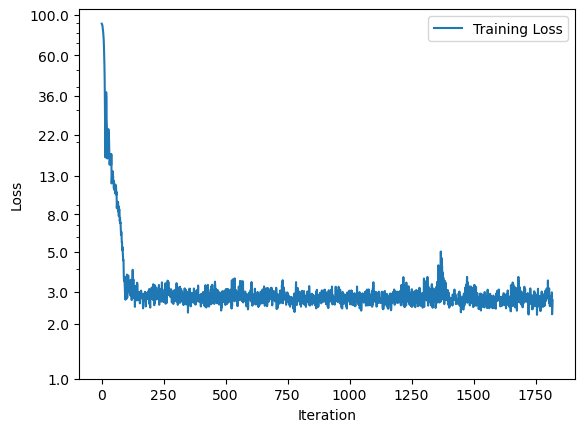

In [97]:
import matplotlib.pyplot as plt
plt.semilogy(loss_data, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yticks(ticks=np.round(np.logspace(0,2, num=10)), labels=np.round(np.logspace(0,2, num=10)))
plt.legend()
plt.show()

In [68]:
Model.eval(test_dataloader)

TypeError: Module.eval() takes 1 positional argument but 2 were given